### Face Landmarks Detection - Improved Solution

In [1]:
# Bu not defteri, orijinal FaceLandmarksDetection projesine alternatif ve geliştirilmiş bir çözüm sunar.
# Yapılan değişiklikler ve nedenleri not defterinin sonunda açıklanmıştır.

In [2]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

In [4]:
class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)
        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])
        image = imutils.rotate(np.array(image), angle)
        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        # Color Jitter sadece parlaklık ve kontrast ile sınırlandırıldı
        color_jitter = transforms.ColorJitter(brightness=0.3, contrast=0.3)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)
        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [5]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, transform=None):
        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))
            self.crops.append(filename[0].attrib)
            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')
        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5
        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

In [6]:
# Veri setini ayırma
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("Train Set Length: {}".format(len_train_set))
print("Valid Set Length: {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# ÖNEMLİ: num_workers=0 olarak ayarlandı!
# Colab'da num_workers > 0 multiprocessing hatalarına yol açabilir.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=0)

Train Set Length: 6000
Valid Set Length: 666


In [7]:
class MobileNetV2Face(nn.Module):
    def __init__(self, num_classes=136):
        super().__init__()
        self.model_name = 'mobilenet_v2'
        # Pretrained MobileNetV2 yükleniyor
        self.model = models.mobilenet_v2(pretrained=True)

        # İlk katmanı 1 kanal (Grayscale) alacak şekilde güncelliyoruz
        # MobileNetV2 features[0][0] Conv2d katmanıdır
        self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

        # Sınıflandırıcı katmanını değiştiriyoruz
        # Son katman (classifier[1]) Linear katmandır. Giriş özelliği last_channel (1280) olur.
        self.model.classifier[1] = nn.Linear(self.model.last_channel, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [8]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    sys.stdout.flush()

In [9]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# GPU varsa kullan, yoksa CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.autograd.set_detect_anomaly(True)
network = MobileNetV2Face()
network.to(device)

# 1. Geliştirme: Loss Fonksiyonu Değişikliği
criterion = nn.SmoothL1Loss()

# 2. Geliştirme: Optimizer Değişikliği
optimizer = optim.AdamW(network.parameters(), lr=0.001, weight_decay=1e-5)

# 3. Geliştirme: Scheduler Eklemesi
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

loss_min = np.inf
num_epochs = 15

train_losses = []
valid_losses = []

start_time = time.time()

for epoch in range(1, num_epochs + 1):
    loss_train = 0
    loss_valid = 0

    # ---------------- TRAIN ----------------
    network.train()
    for step, (images, landmarks) in enumerate(train_loader, 1):
        # Verileri cihaza taşı ve float32'ye çevir
        images = images.to(device)
        landmarks = landmarks.float().view(landmarks.size(0), -1).to(device)

        predictions = network(images)

        optimizer.zero_grad()
        loss_train_step = criterion(predictions, landmarks)
        loss_train_step.backward()
        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train / step
        print_overwrite(step, len(train_loader), running_loss, 'train')

    loss_train /= len(train_loader)

    # ---------------- VALID ----------------
    network.eval()
    with torch.no_grad():
        for step, (images, landmarks) in enumerate(valid_loader, 1):
            images = images.to(device)
            landmarks = landmarks.float().view(landmarks.size(0), -1).to(device)

            predictions = network(images)
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid / step
            print_overwrite(step, len(valid_loader), running_loss, 'valid')

    loss_valid /= len(valid_loader)

    train_losses.append(loss_train)
    valid_losses.append(loss_valid)

    # Scheduler
    scheduler.step(loss_valid)
    current_lr = optimizer.param_groups[0]['lr']

    print('\n--------------------------------------------------')
    print(f'Epoch: {epoch}')
    print(f'Train Loss: {loss_train:.4f}')
    print(f'Valid Loss: {loss_valid:.4f}')
    print(f'Learning Rate: {current_lr:.6f}')
    print('--------------------------------------------------')

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'face_landmarks_improved.pth')
        print(f"\n✅ Minimum Validation Loss: {loss_min:.4f}")
        print("Model Saved\n")

print('Training Complete')
print(f"Total Elapsed Time: {time.time() - start_time:.2f} s")

Using device: cpu
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 13.6M/13.6M [00:01<00:00, 10.5MB/s]
/tmp/ipython-input-1487348210.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  new_landmarks = np.matmul(landmarks, transformation_matrix)


Valid Steps: 84/84  Loss: 0.0025 
--------------------------------------------------
Epoch: 1
Train Loss: 0.0092
Valid Loss: 0.0025
Learning Rate: 0.001000
--------------------------------------------------

✅ Minimum Validation Loss: 0.0025
Model Saved

Valid Steps: 84/84  Loss: 0.0013 
--------------------------------------------------
Epoch: 2
Train Loss: 0.0025
Valid Loss: 0.0013
Learning Rate: 0.001000
--------------------------------------------------

✅ Minimum Validation Loss: 0.0013
Model Saved

Valid Steps: 84/84  Loss: 0.0007 
--------------------------------------------------
Epoch: 3
Train Loss: 0.0015
Valid Loss: 0.0007
Learning Rate: 0.001000
--------------------------------------------------

✅ Minimum Validation Loss: 0.0007
Model Saved

Valid Steps: 84/84  Loss: 0.0025 
--------------------------------------------------
Epoch: 4
Train Loss: 0.0011
Valid Loss: 0.0025
Learning Rate: 0.001000
--------------------------------------------------
Valid Steps: 84/84  Loss: 0.

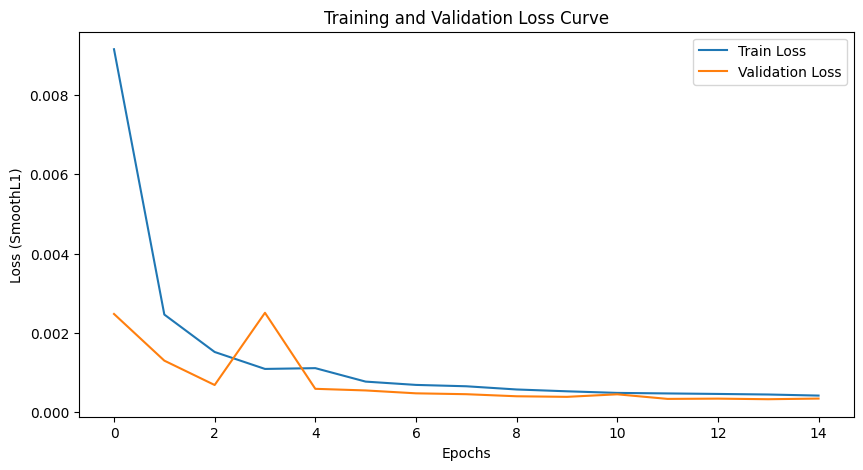

In [10]:
# Eğitim grafiklerini çizdir
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (SmoothL1)')
plt.legend()
plt.title('Training and Validation Loss Curve')
plt.show()

# Neden Bu Değişiklikler Yapıldı?

Bu çözümde, orijinal `ResNet18` + `MSELoss` yaklaşımı yerine aşağıdaki geliştirmeler uygulanmıştır:

### 1. Model: ResNet18 yerine MobileNetV2
- **Sebep:** MobileNetV2, ResNet18'e kıyasla çok daha hafif (daha az parametreli) ve hızlı bir modeldir. Yüz işaret tespiti (Face Landmark Detection) gibi problemler genellikle mobil veya gerçek zamanlı uygulamalarda kullanılır. MobileNetV2, `Inverted Residuals` ve `Linear Bottlenecks` yapısı sayesinde performans/hız dengesini mükemmel kurar. Doğruluktan çok az ödün vererek çok daha hızlı çıkarım (inference) süreleri sağlar.

### 2. Kayıp Fonksiyonu: MSELoss yerine SmoothL1Loss
- **Sebep:** Regresyon problemlerinde MSE (Mean Squared Error), hataların karesini aldığı için 'outlier' (aykırı) tahminlere çok büyük cezalar verir. Bu durum, eğitimin başlarında veya zor örneklerde kararsızlığa yol açabilir. `SmoothL1Loss`, hata küçükken L2 normu (karesel), hata büyükken L1 normu (mutlak) gibi davranarak gradient patlamalarını engeller ve daha stabil bir yakınsama sağlar.

### 3. Optimizasyon: AdamW ve LR Scheduler
- **AdamW:** Standart Adam optimizasyonuna göre 'weight decay' işlemini daha doğru uygular. Bu, modelin genelleme yeteneğini artırır (regularization).
- **ReduceLROnPlateau:** Sabit bir öğrenme oranı (learning rate) yerine, modelin öğrenmesi duraksadığında (validation loss düşmediğinde) öğrenme oranını dinamik olarak azaltır. Bu, modelin minimum hataya daha hassas bir şekilde inebilmesini (fine-tuning) sağlar.